# Detect the distribution of cosine similarities among all concepts in the CSpace
Empirically, cos == 0 is extremely unlikely, much more likely cos == 1. But what is the true distribution?
this will be useful to compute some other statistics about each concept with respect to the others.

In [1]:
!pip install compress_fasttext

In [2]:
from gensim.models import KeyedVectors
import compress_fasttext
import numpy as np
from distribution import *

In [3]:
smodel = KeyedVectors.load('models/cspace.100k.kv.bin','r')
#csmodel =  compress_fasttext.prune_ft_freq(smodel, pq=True, qdim=76, new_vocab_size=100000, fp16=True)

In [4]:
# vectors with unit norm
W = smodel.get_normed_vectors()
max_n=50000
np.save('models/cspace.50k.kv.bin.vectors.norm.npy',W[:max_n])
W = np.load('models/cspace.50k.kv.bin.vectors.norm.npy',mmap_mode='r')
W.shape

(50000, 152)

In [5]:
Wsq=W @ W.T

Wsq contains cosine similarities between pairs of embeddings. 

The diagonal is always 1, and the low-triangular part is equal to the up-triangular part (symmetric matrix). 

Visualize: 
1) distribution of cosine similarities
2) normalize matrix Wsq between 0 and 1 given the distribution computed in 1)
3) show samples of very similar (value near to 1) and very dissimilar (value near to 0) entries
   

In [8]:
print(Wsq[10,10])
print(Wsq[10,11])
print(Wsq[11,10])

print(smodel.index_to_key[10])
print(smodel.index_to_key[11])

0.9999999
0.8835351
0.8835351
as
by


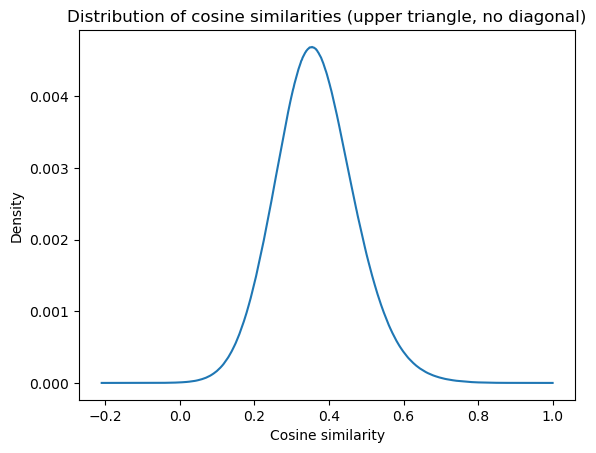

Distribution diagnostics: {'n': 50000, 'expected_pairs': 1249975000, 'counted_pairs': 1249975000, 'dropped_pairs': 0, 'nan_count': 0, 'inf_count': 0, 'min_seen': -0.20289388298988342, 'max_seen': 0.9953970313072205, 'cdf_last': 1.0, 'hist_range': (-0.21, 1.0), 'bins': 1000}


In [13]:
# 1) Distribution (upper triangle, no diagonal)
bin_edges, hist_counts, pdf, cdf, stats = build_distribution(Wsq, bins=BINS, hist_range=(-0.21, 1.0), row_block=ROW_BLOCK)

In [12]:
np.cumsum(pdf)[-1]

0.9999999999999992

In [26]:
# print quantile thresholds
lo_thr, hi_thr = quantile_thresholds_from_hist(bin_edges, hist_counts, cdf, 0.5, HI_Q)
print(f"Approx low-sim threshold (~{50:.2f}th pct): {lo_thr:.4f}")
print(f"Approx high-sim threshold (~{HI_Q*100:.2f}th pct): {hi_thr:.4f}")

Approx low-sim threshold (~50.00th pct): 0.3587
Approx high-sim threshold (~99.90th pct): 0.7411


In [15]:
# 2) Normalize to [0,1] using empirical CDF
# NOTE: For 50k x 50k use out_memmap_path to avoid RAM blowup
Wnorm = normalize_matrix_cdf(Wsq, bin_edges, cdf,
                             row_block=ROW_BLOCK,
                             out_memmap_path='models/cspace.50k.cos.norm.npy',
                             out_dtype=NORMALIZED_DTYPE)

In [17]:
# Quick sanity check plot on a small random sample of entries
sample_idx = np.triu_indices(Wsq.shape[0], k=1)

rng = np.random.default_rng(42)
sel = rng.choice(sample_idx[0].size, size=min(200000, sample_idx[0].size), replace=False)
sel.shape

(200000,)

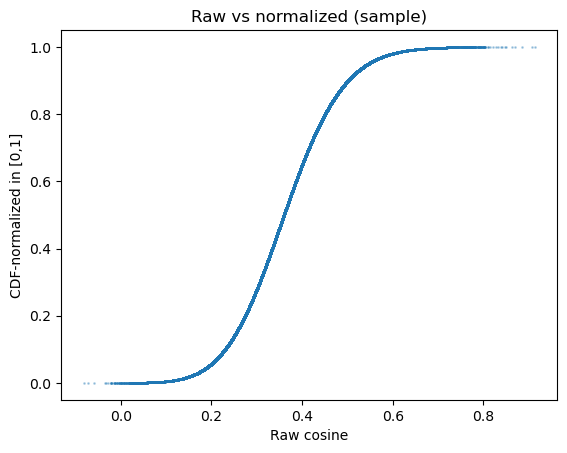

In [18]:
raw_sample = Wsq[sample_idx[0][sel], sample_idx[1][sel]]
norm_sample = cdf_normalizer(raw_sample, bin_edges, cdf)

plt.figure()
plt.scatter(raw_sample, norm_sample, s=1, alpha=0.3)
plt.xlabel("Raw cosine")
plt.ylabel("CDF-normalized in [0,1]")
plt.title("Raw vs normalized (sample)")
plt.show()

In [19]:
# 3) Show samples of very similar and very dissimilar entries
top, bottom = find_extremes(Wsq, k=10, row_block=ROW_BLOCK)



Top (very similar) off-diagonal pairs:
(25918, 40367) = 0.995397
(24355, 26146) = 0.995342
(33300, 34748) = 0.995248
(42015, 47385) = 0.995186
(47324, 49178) = 0.995073
(35862, 41338) = 0.995004
(18128, 20606) = 0.994943
(33445, 35862) = 0.994937
(34748, 36834) = 0.994895
(47325, 49113) = 0.994893

Bottom (very dissimilar) off-diagonal pairs:
(16509, 30657) = -0.202894
(4884, 39985) = -0.201316
(27554, 49791) = -0.187496
(10871, 30657) = -0.185135
(36880, 48136) = -0.180361
(27554, 48172) = -0.177461
(3375, 35618) = -0.177209
(6097, 48136) = -0.174160
(14908, 48136) = -0.172814
(7250, 48136) = -0.171308


In [20]:

print("\nTop (very similar) off-diagonal pairs:")
for val, i, j in top:
    print(f"({smodel.index_to_key[i]}, {smodel.index_to_key[j]}) = {val:.6f} (norm: {Wnorm[i,j]:.6f})")

print("\nBottom (very dissimilar) off-diagonal pairs:")
for val, i, j in bottom:
    print(f"({smodel.index_to_key[i]}, {smodel.index_to_key[j]}) = {val:.6f} (norm: {Wnorm[i,j]:.6f})")



Top (very similar) off-diagonal pairs:
(resuspend_in_μl, resuspend_in_µl) = 0.995397 (norm: 1.000000)
(inlineformula31, inlineformula30) = 0.995342 (norm: 1.000000)
(inlineformula53, inlineformula52) = 0.995248 (norm: 1.000000)
(inlineformula74, inlineformula73) = 0.995186 (norm: 1.000000)
(inlineformula104, inlineformula105) = 0.995073 (norm: 1.000000)
(inlineformula48, inlineformula47) = 0.995004 (norm: 1.000000)
(inlineformula12, inlineformula13) = 0.994943 (norm: 1.000000)
(inlineformula49, inlineformula48) = 0.994937 (norm: 1.000000)
(inlineformula52, inlineformula51) = 0.994895 (norm: 1.000000)
(inlineformula94, inlineformula93) = 0.994893 (norm: 1.000000)

Bottom (very dissimilar) off-diagonal pairs:
(ido, g′) = -0.202894 (norm: 0.000000)
(bin, ifn‐γ) = -0.201316 (norm: 0.000000)
(pres, 4k) = -0.187496 (norm: 0.000000)
(mir, g′) = -0.185135 (norm: 0.000000)
(deep_learning-based, ‐1) = -0.180361 (norm: 0.000000)
(pres, 3k) = -0.177461 (norm: 0.000000)
(please, pd‐1) = -0.177209 

In [22]:
smodel.index_to_key[25918]

'resuspend_in_μl'

In [23]:
smodel.index_to_key[40367]

'resuspend_in_µl'

In [24]:
smodel.index_to_key[25918] == smodel.index_to_key[40367]


False